##Multiclass Image classifier using Keras and Convolutional Neural Networks to identify single use plastics (Plastic Bag, Plastic Bottle and Plastic Straws)

### 1. Loading the data and importing the required libraries

Data Set Folder Structure:

> Plastic_multi_data:

      - Plastic Bag:            
            - Train (600 Images)
            - Validation (150 Images)
            - Test (25 Images)
      - Plastic Bottle
            - Train (600 Images)
            - Validation (150 Images)
            - Test (25 Images)
      - Plastic Straw
            - Train (600 Images)
            - Validation (150 Images)
            - Test (25 Images)

In [16]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive
#https://drive.google.com/open?id=19h96j678nVd7FtZ_zzQfj0YD8O4iMr22
#https://drive.google.com/open?id=19h96j678nVd7FtZ_zzQfj0YD8O4iMr22
zip_id = '19h96j678nVd7FtZ_zzQfj0YD8O4iMr22'

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('DATA'):
    os.makedirs('DATA')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('Plastic_multi_data.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('Plastic_multi_data.zip', 'r')
zip_ref.extractall('DATA/')
zip_ref.close()

Uncompressing zip file


In [0]:

%matplotlib inline
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
import os
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger
from keras import backend as K
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import applications
from keras.utils.np_utils import to_categorical
import math
import cv2


### 2. Initializing parameters

In [0]:
# Initializing files to save the results
train_data_dir = 'DATA/train' 
validation_data_dir = 'DATA/valid' 
test_data_dir = 'DATA/test' 

In [0]:
# Initializing files to save the results
model_summary_file = "model_summary.txt"
test_file = "test_file.txt"
model_file = "model.h5"
fully_connected_weights_path = 'fully_connected_multiclass_model.h5'

In [0]:
# Hyperparameters
image_size = 200
image_height, image_width = image_size, image_size
epochs = 100
batch_size = 10
num_training_samples = 1800
num_validation_samples = 450
num_test_samples = 75

In [0]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, image_height, image_width)
else:
    input_shape = (image_width, image_height, 3)

### 3. Feature extraction from a pre-trained network - VGG 16 trained on Imagenet dataset

In [22]:
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 4. Data Augmentation to deal with less data

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
       shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

valid_data_gen = ImageDataGenerator(rescale=1. / 255)
test_data_generator = ImageDataGenerator(rescale=1. / 255)


### 5. Data Preparation for training  - Loading the data and get features from the pre-trained model (VGG-16)

In [24]:

training_data_generator =train_datagen.flow_from_directory(train_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)
vgg16_features_train = model.predict_generator(
        training_data_generator, 1800 // batch_size)
np.save(open('vgg16_features_train.npy', 'wb'),
            vgg16_features_train)

validation_data_generator = valid_data_gen.flow_from_directory(
        validation_data_dir,
        target_size=(image_height, image_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)
vgg16_features_validation = model.predict_generator(
        validation_data_generator, 450 // batch_size)
np.save(open('vgg16_features_validation.npy', 'wb'),
            vgg16_features_validation)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical", 
    shuffle=False)
vgg16_features_test = model.predict_generator(
        validation_data_generator, 75 // batch_size)
np.save(open('vgg16_features_test.npy', 'wb'),
            vgg16_features_test)

Found 1800 images belonging to 3 classes.
Found 450 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


In [0]:
# Load the data pre-trained by VGG 16 model
train_data = np.load(open('vgg16_features_train.npy', 'rb'))
train_labels = to_categorical(training_data_generator.classes,num_classes=len(training_data_generator.class_indices))
# save the class indices to use use later in predictions
np.save('class_indices.npy', training_data_generator.class_indices)

validation_data = np.load(open('vgg16_features_validation.npy', 'rb'))
validation_labels = to_categorical(validation_data_generator.classes,num_classes=len(validation_data_generator.class_indices))

test_data = np.load(open('vgg16_features_test.npy', 'rb'))
test_labels = to_categorical(test_generator.classes,num_classes=len(test_generator.class_indices))

### 6. Model Training - Train the data with fully connected layers

In [26]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.SGD(lr=1e-4, decay=1e-4,momentum=0.9),
                  loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
model.save(fully_connected_weights_path)


Train on 1800 samples, validate on 450 samples
Epoch 1/100
1800/1800 [==============================] - 3s 2ms/step - loss: 0.9934 - acc: 0.6333 - val_loss: 0.4095 - val_acc: 0.8200
Epoch 2/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5806 - acc: 0.7761 - val_loss: 0.2425 - val_acc: 0.9156
Epoch 3/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4532 - acc: 0.8272 - val_loss: 0.1924 - val_acc: 0.9311
Epoch 4/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4218 - acc: 0.8511 - val_loss: 0.1768 - val_acc: 0.9356
Epoch 5/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.3856 - acc: 0.8622 - val_loss: 0.1790 - val_acc: 0.9267
Epoch 6/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.3220 - acc: 0.8794 - val_loss: 0.1683 - val_acc: 0.9333
Epoch 7/100
1800/1800 [==============================] - 2s 1ms/step - loss: 0.2955 - acc: 0.8956 - val_loss: 0.1533 - val_acc: 0.9400
Epoch 8/

In [27]:
model.summary()
#Save the Model summary
with open(model_summary_file,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
__________

### 7. Model Performance in training and validation sets

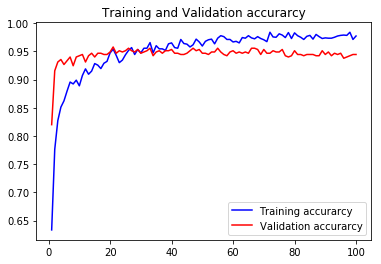

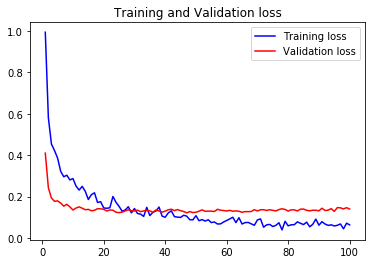

In [28]:
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


### 8. Model Evaluation on Validation Set

In [30]:
#Confution Matrix and Classification Report
test = np.load('vgg16_features_validation.npy')
predictions = model.predict_classes(test)
true_classes = validation_data_generator.classes
class_labels = list(validation_data_generator.class_indices.keys())  
print('Confusion Matrix for validation set:')
print(confusion_matrix(true_classes, predictions))
print('Classification Report for validation set:')
target_names = ['Plastic bag','Plastic bottle','Plastic straw']
print(classification_report(true_classes, predictions, target_names=class_labels))

Confusion Matrix for validation set:
[[134  10   6]
 [  1 145   4]
 [  2   2 146]]
Classification Report for validation set:
                precision    recall  f1-score   support

   Plastic bag       0.98      0.89      0.93       150
Plastic bottle       0.92      0.97      0.94       150
 Plastic straw       0.94      0.97      0.95       150

     micro avg       0.94      0.94      0.94       450
     macro avg       0.95      0.94      0.94       450
  weighted avg       0.95      0.94      0.94       450



In [35]:
print("Validation Set Accuracy:",accuracy_score(true_classes, predictions)*100,"%")

Validation Set Accuracy: 94.44444444444444 %


### 9. Make prediction on unseen data

In [0]:
def prediction_model(bottleneck_prediction):
   # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.load_weights(fully_connected_weights_path)
    return model

DATA/test/Plastic bag/bag (119).jpg
Predicted class: Plastic bag


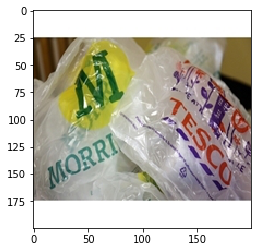

DATA/test/Plastic bag/bag (141).jpg
Predicted class: Plastic bag


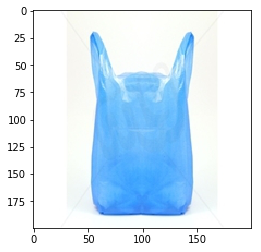

DATA/test/Plastic bag/bag (149).jpg
Predicted class: Plastic bag


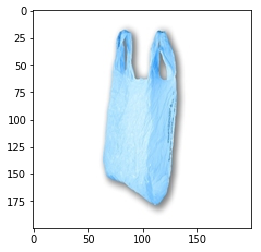

DATA/test/Plastic bag/bag (150).jpg
Predicted class: Plastic bag


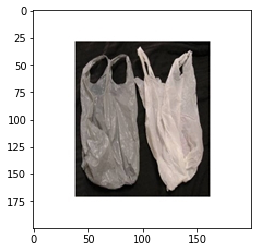

DATA/test/Plastic bag/bag (40).jpg
Predicted class: Plastic bag


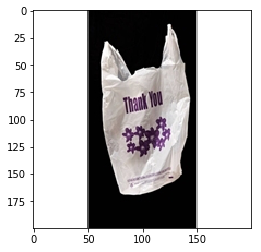

DATA/test/Plastic bag/bag (428).jpg
Predicted class: Plastic bag


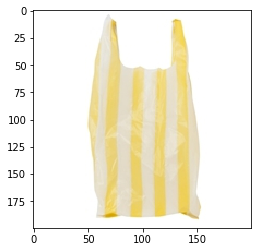

DATA/test/Plastic bag/bag (429).jpg
Predicted class: Plastic bag


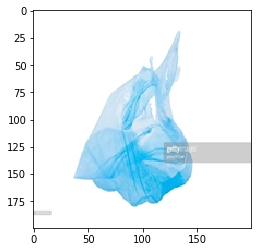

DATA/test/Plastic bag/bag (430).jpg
Predicted class: Plastic bag


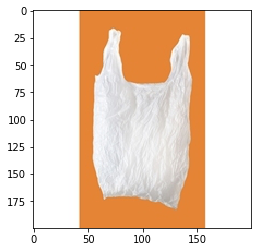

DATA/test/Plastic bag/bag (48).jpg
Predicted class: Plastic bag


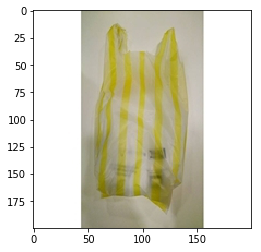

DATA/test/Plastic bag/bag (49).jpg
Predicted class: Plastic bag


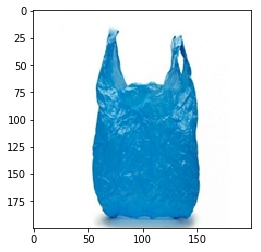

DATA/test/Plastic bag/bag (498).jpg
Predicted class: Plastic bag


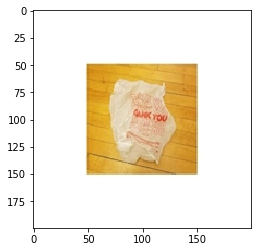

DATA/test/Plastic bag/bag (506).jpg
Predicted class: Plastic bag


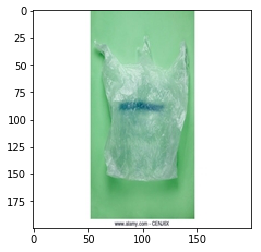

DATA/test/Plastic bag/bag (507).jpg
Predicted class: Plastic bag


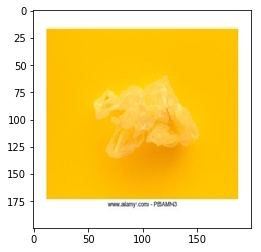

DATA/test/Plastic bag/bag (79).jpg
Predicted class: Plastic bag


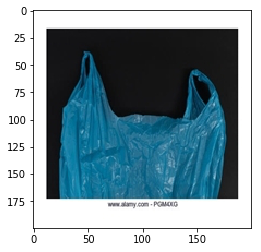

DATA/test/Plastic bag/bag (80).jpg
Predicted class: Plastic bag


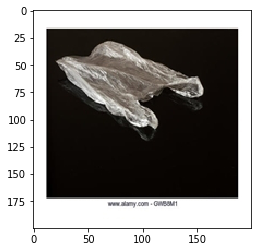

DATA/test/Plastic bag/pic (28).jpg
Predicted class: Plastic bag


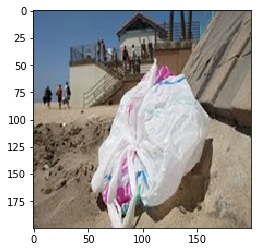

DATA/test/Plastic bag/pic (29).jpg
Predicted class: Plastic bag


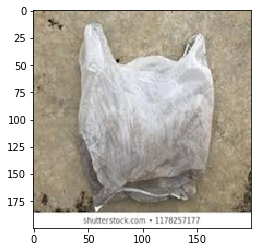

DATA/test/Plastic bag/pic (30).jpg
Predicted class: Plastic bottle


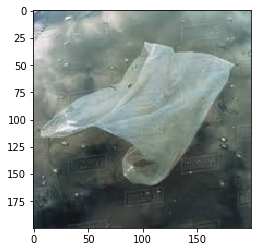

DATA/test/Plastic bag/pic_1100 (1).jpg
Predicted class: Plastic bag


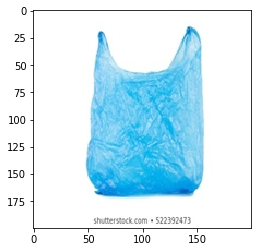

DATA/test/Plastic bag/pic_1106 (4).jpg
Predicted class: Plastic bag


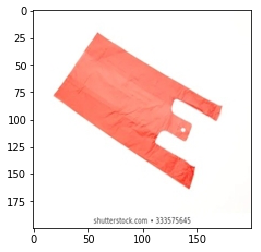

DATA/test/Plastic bag/pic_1111 (2).jpg
Predicted class: Plastic bag


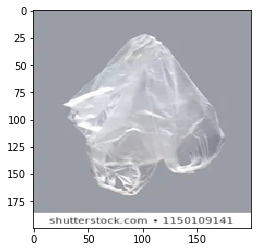

DATA/test/Plastic bag/pic_1111 (3).jpg
Predicted class: Plastic bag


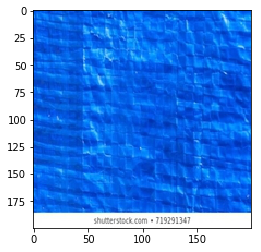

DATA/test/Plastic bag/pic_1111 (4).jpg
Predicted class: Plastic bottle


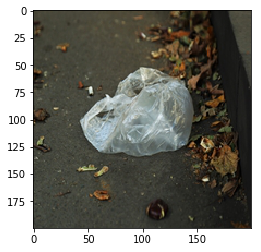

DATA/test/Plastic bag/pic_1117 (2).jpg
Predicted class: Plastic bag


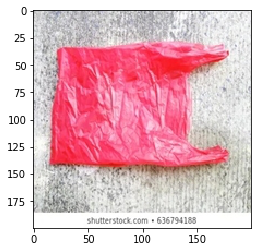

DATA/test/Plastic bag/pic_1117 (3).jpg
Predicted class: Plastic bag


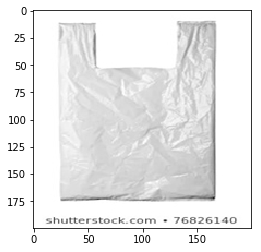

DATA/test/Plastic bottle/bottle (321).jpg
Predicted class: Plastic bottle


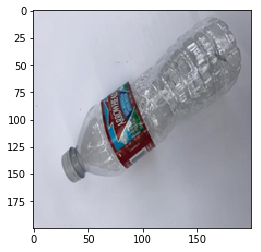

DATA/test/Plastic bottle/bottle (478).jpg
Predicted class: Plastic bottle


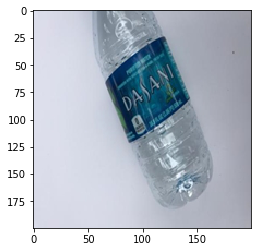

DATA/test/Plastic bottle/bottle (480).jpg
Predicted class: Plastic bottle


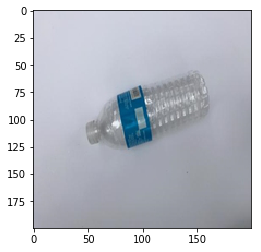

DATA/test/Plastic bottle/pic_1114 (4).jpg
Predicted class: Plastic bottle


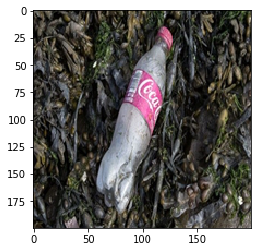

DATA/test/Plastic bottle/pic_1114 (5).jpg
Predicted class: Plastic bottle


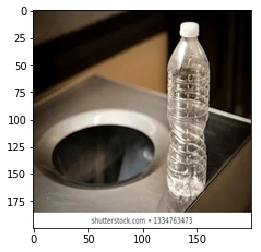

DATA/test/Plastic bottle/pic_1115 (5).jpg
Predicted class: Plastic bottle


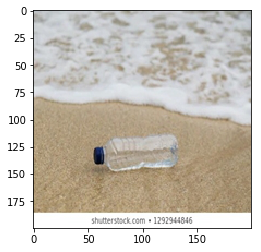

DATA/test/Plastic bottle/pic_1135 (4).jpg
Predicted class: Plastic bottle


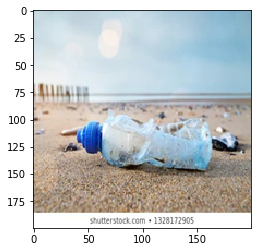

DATA/test/Plastic bottle/pic_1137 (3).jpg
Predicted class: Plastic bottle


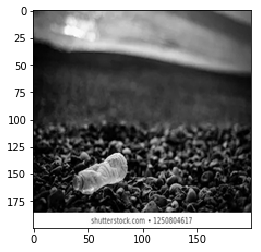

DATA/test/Plastic bottle/pic_1147.jpg
Predicted class: Plastic bottle


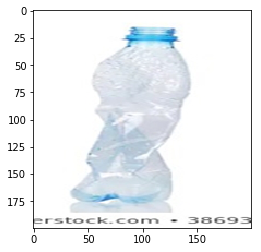

DATA/test/Plastic bottle/pic_1193.jpg
Predicted class: Plastic bottle


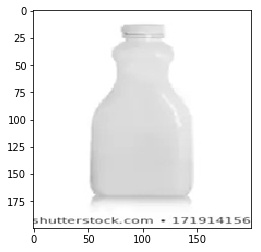

DATA/test/Plastic bottle/pic_1197 (2).jpg
Predicted class: Plastic bottle


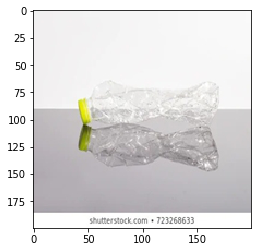

DATA/test/Plastic bottle/pic_1248 (2).jpg
Predicted class: Plastic bottle


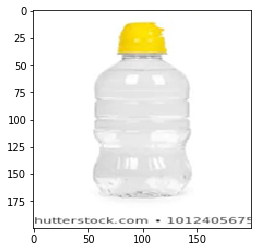

DATA/test/Plastic bottle/pic_1248.jpg
Predicted class: Plastic bottle


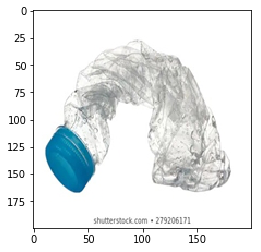

DATA/test/Plastic bottle/pic_1252 (2).jpg
Predicted class: Plastic bottle


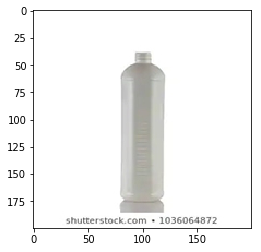

DATA/test/Plastic bottle/pic_1272.jpg
Predicted class: Plastic bottle


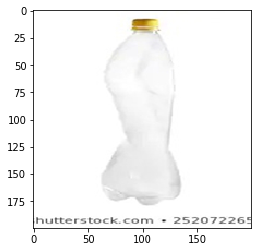

DATA/test/Plastic bottle/pic_1326.jpg
Predicted class: Plastic bottle


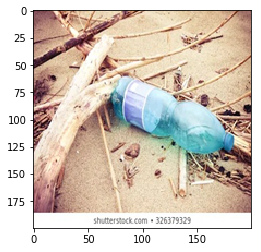

DATA/test/Plastic bottle/pic_1368.jpg
Predicted class: Plastic bottle


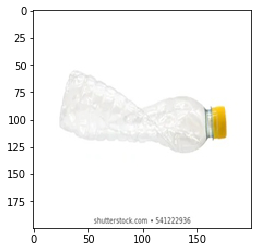

DATA/test/Plastic bottle/pic_1369.jpg
Predicted class: Plastic bottle


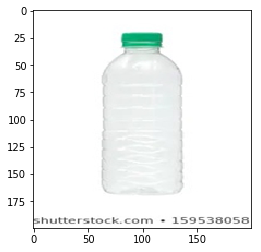

DATA/test/Plastic bottle/pic_1376.jpg
Predicted class: Plastic bottle


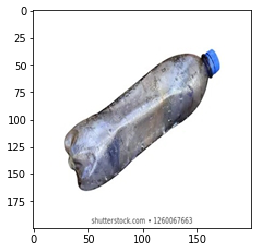

DATA/test/Plastic bottle/pic_1406.jpg
Predicted class: Plastic bottle


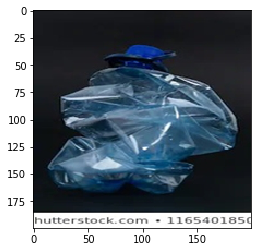

DATA/test/Plastic bottle/pic_1436.jpg
Predicted class: Plastic bottle


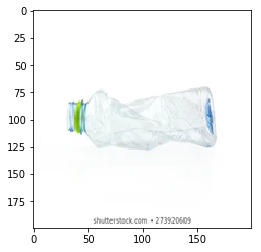

DATA/test/Plastic bottle/pic_1437.jpg
Predicted class: Plastic bottle


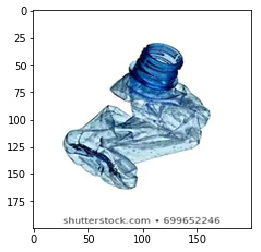

DATA/test/Plastic bottle/pic_1456.jpg
Predicted class: Plastic bottle


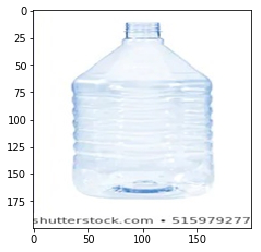

DATA/test/Plastic bottle/pic_1457.jpg
Predicted class: Plastic bottle


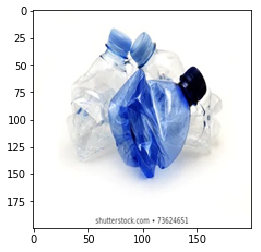

DATA/test/Plastic bottle/pic_1458.jpg
Predicted class: Plastic bottle


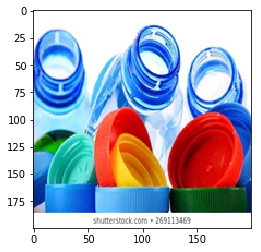

DATA/test/Plastic straw/pic_1094.jpg
Predicted class: Plastic straw


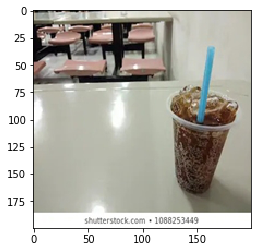

DATA/test/Plastic straw/pic_1146.jpg
Predicted class: Plastic straw


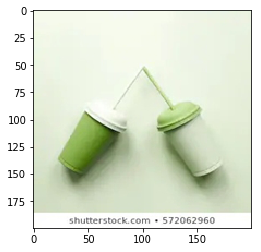

DATA/test/Plastic straw/pic_1160.jpg
Predicted class: Plastic straw


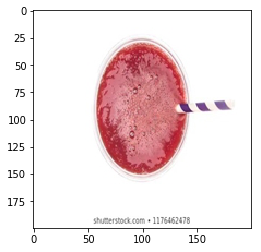

DATA/test/Plastic straw/pic_1165.jpg
Predicted class: Plastic straw


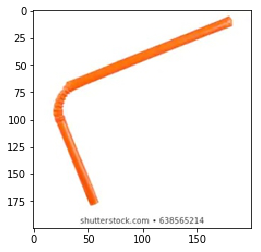

DATA/test/Plastic straw/pic_1318.jpg
Predicted class: Plastic straw


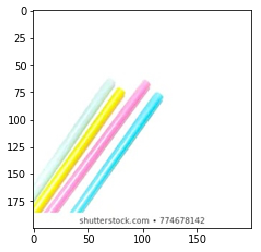

DATA/test/Plastic straw/pic_1341.jpg
Predicted class: Plastic straw


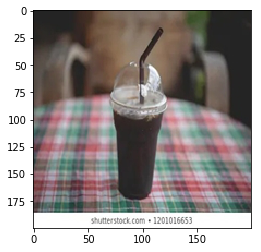

DATA/test/Plastic straw/pic_1347.jpg
Predicted class: Plastic straw


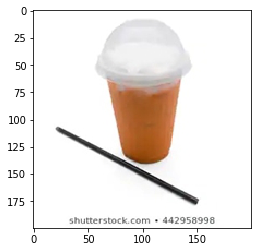

DATA/test/Plastic straw/pic_1457.jpg
Predicted class: Plastic straw


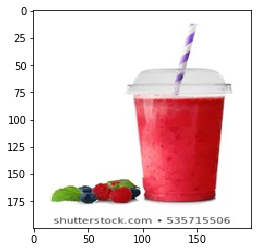

DATA/test/Plastic straw/pic_1506.jpg
Predicted class: Plastic straw


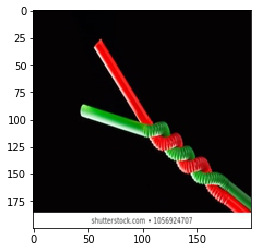

DATA/test/Plastic straw/pic_1508.jpg
Predicted class: Plastic straw


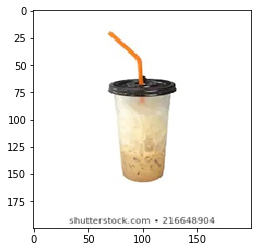

DATA/test/Plastic straw/pic_219.jpg
Predicted class: Plastic straw


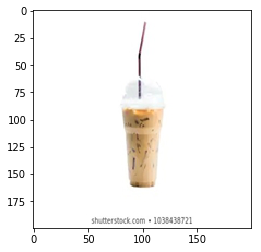

DATA/test/Plastic straw/pic_273.jpg
Predicted class: Plastic straw


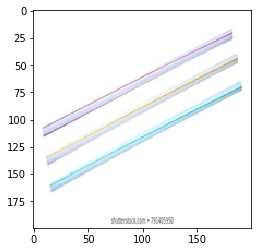

DATA/test/Plastic straw/pic_325.jpg
Predicted class: Plastic straw


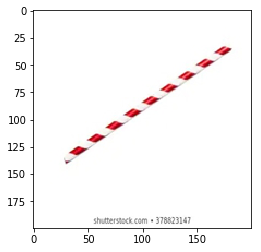

DATA/test/Plastic straw/pic_329.jpg
Predicted class: Plastic straw


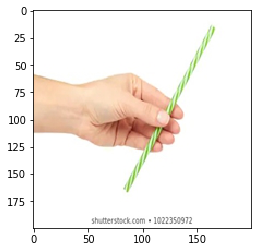

DATA/test/Plastic straw/pic_331.jpg
Predicted class: Plastic straw


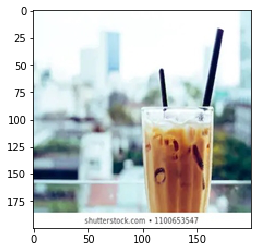

DATA/test/Plastic straw/pic_379.jpg
Predicted class: Plastic straw


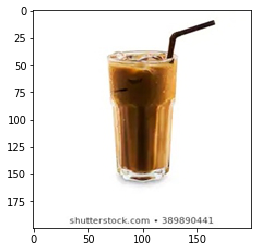

DATA/test/Plastic straw/pic_381.jpg
Predicted class: Plastic straw


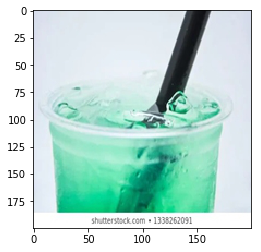

DATA/test/Plastic straw/pic_517.jpg
Predicted class: Plastic straw


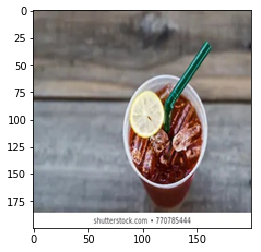

DATA/test/Plastic straw/pic_586.jpg
Predicted class: Plastic straw


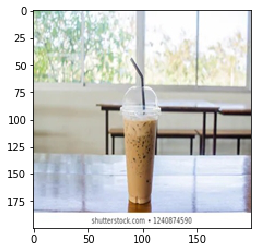

DATA/test/Plastic straw/pic_596.jpg
Predicted class: Plastic straw


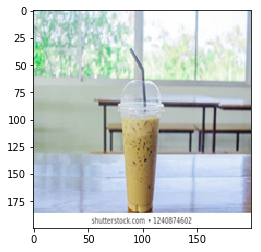

DATA/test/Plastic straw/pic_841.jpg
Predicted class: Plastic straw


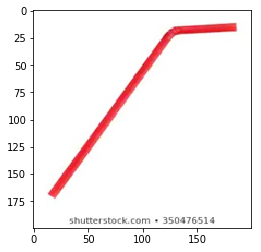

DATA/test/Plastic straw/pic_887.jpg
Predicted class: Plastic straw


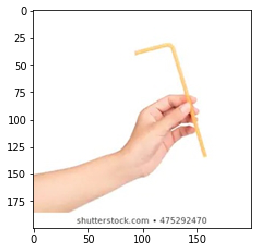

DATA/test/Plastic straw/pic_891.jpg
Predicted class: Plastic straw


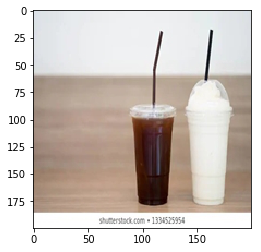

DATA/test/Plastic straw/pic_940.jpg
Predicted class: Plastic straw


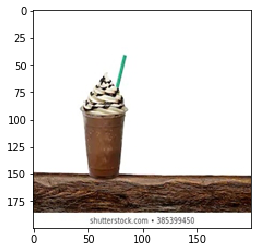

DATA/test/Plastic straw/pic_947.jpg
Predicted class: Plastic straw


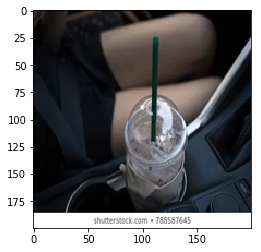

In [38]:
import glob
import os
num_of_files = sum([len(files) for r, d, files in os.walk(test_data_dir)])
class_dictionary = np.load('class_indices.npy').item()
# build the VGG16 network
model = applications.VGG16(include_top=False, weights='imagenet')
probs = []
#select the path
for index in range(num_of_files):
  image_path = test_data_dir + "/" +test_generator.filenames[index]
  print(image_path)
  image = load_img(image_path, target_size=(200, 200))
  encoded_img = img_to_array(image)
  # important! otherwise the predictions will be '0'
  encoded_img = encoded_img / 255
  encoded_img = np.expand_dims(encoded_img, axis=0)
  bottleneck_prediction = model.predict(encoded_img)
  pred_model = prediction_model(bottleneck_prediction)
  class_predicted = pred_model.predict_classes(bottleneck_prediction)
  probability = pred_model.predict_proba(bottleneck_prediction)
  probs.append(probability)
  inID = class_predicted[0]
  inv_map = {v: k for k, v in class_dictionary.items()}
  label = inv_map[inID]
  print("Predicted class:",label)
  plt.imshow(image)
  plt.show()

### 10. Model Evaluation on Test set/Unseen Data

In [39]:
predictions = np.array(probs)
predictions = predictions.reshape(num_of_files,3)
y_pred = np.argmax(predictions, axis=-1)
print(y_pred)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   
print(confusion_matrix(test_generator.classes, y_pred))
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
[[23  2  0]
 [ 0 25  0]
 [ 0  0 25]]
                precision    recall  f1-score   support

   Plastic bag       1.00      0.92      0.96        25
Plastic bottle       0.93      1.00      0.96        25
 Plastic straw       1.00      1.00      1.00        25

     micro avg       0.97      0.97      0.97        75
     macro avg       0.98      0.97      0.97        75
  weighted avg       0.98      0.97      0.97        75



In [42]:
print("Test Set Accuracy:",accuracy_score(true_classes, y_pred)*100,"%")

Test Set Accuracy: 97.33333333333334 %
